In [56]:
import scanpy as sc
import omicverse as ov
import pandas as pd
import numpy as np
import os
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import commot
ov.utils.download_pathway_database()
pathway_dict=ov.utils.geneset_prepare('genesets/GO_Biological_Process_2021.txt',organism='Human')

......Pathway Geneset download start: GO_Biological_Process_2021
......Loading dataset from genesets/GO_Biological_Process_2021.txt
......Pathway Geneset download start: GO_Cellular_Component_2021
......Loading dataset from genesets/GO_Cellular_Component_2021.txt
......Pathway Geneset download start: GO_Molecular_Function_2021
......Loading dataset from genesets/GO_Molecular_Function_2021.txt
......Pathway Geneset download start: WikiPathway_2021_Human
......Loading dataset from genesets/WikiPathway_2021_Human.txt
......Pathway Geneset download start: WikiPathways_2019_Mouse
......Loading dataset from genesets/WikiPathways_2019_Mouse.txt
......Pathway Geneset download start: Reactome_2022
......Loading dataset from genesets/Reactome_2022.txt
......Pathway Geneset download finished!
......Other Genesets can be dowload in `https://maayanlab.cloud/Enrichr/#libraries`


In [80]:
import re
pattern = r'.*DNA re.*'
matched_elements = [element for element in list(pathway_dict.keys()) if re.search(pattern, element, re.IGNORECASE)]

In [3]:
LA = sc.read_h5ad('/data/jiangjunyao/ji_stereoseq/spatial/decon_h5/LA_.h5ad')
LA.obsm['spatial'] =np.array(LA.obs[['x','y']])
sc.pp.normalize_total(LA, target_sum=1e4)
sc.pp.log1p(LA)
sc.pp.highly_variable_genes(LA, flavor="seurat", n_top_genes=2000)
sc.pp.pca(LA)
sc.pp.neighbors(LA)
sc.tl.leiden(LA,resolution=0.7)

[<AxesSubplot: title={'center': 'Mural.cell'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'Endothelial'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'first_type'}, xlabel='spatial1', ylabel='spatial2'>]

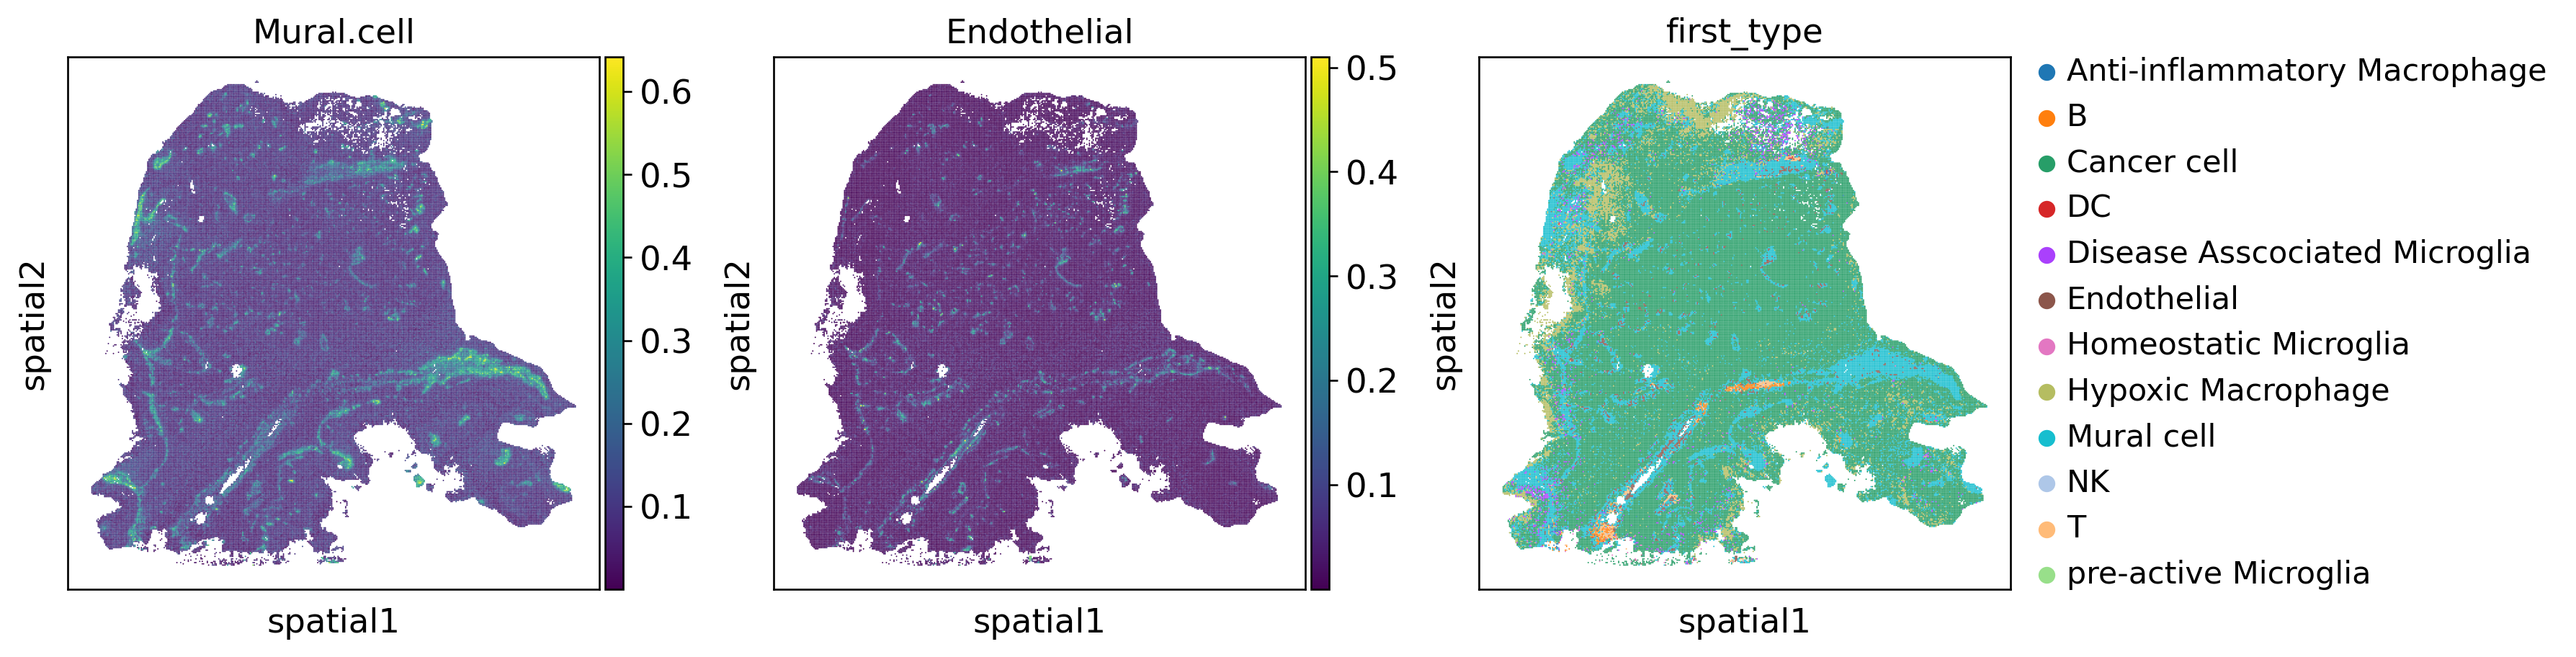

In [122]:
sc.pl.embedding(LA,
                basis='spatial',
          color=['Mural.cell','Endothelial','first_type'],show=False,color_map='viridis')

In [5]:
bv = LA[LA.obs.leiden=='2']
bv.obs.first_type.value_counts()

Mural cell                       10785
Cancer cell                       2895
Endothelial                       1247
Hypoxic Macrophage                 680
Disease Asscociated Microglia      330
T                                  311
B                                  283
Anti-inflammatory Macrophage       197
DC                                  32
Homeostatic Microglia               23
NK                                  11
pre-active Microglia                 1
Name: first_type, dtype: int64

In [6]:
other = LA[LA.obs.leiden.isin(['0','1'])]
other.obs.first_type.value_counts()

Cancer cell                      58423
Mural cell                        7019
Hypoxic Macrophage                6401
Disease Asscociated Microglia     1296
Endothelial                        137
Anti-inflammatory Macrophage        71
T                                   37
Homeostatic Microglia               25
B                                    8
DC                                   8
NK                                   1
Name: first_type, dtype: int64

(<AxesSubplot: title={'center': 'region_type'}, xlabel='spatial1', ylabel='spatial2'>,)

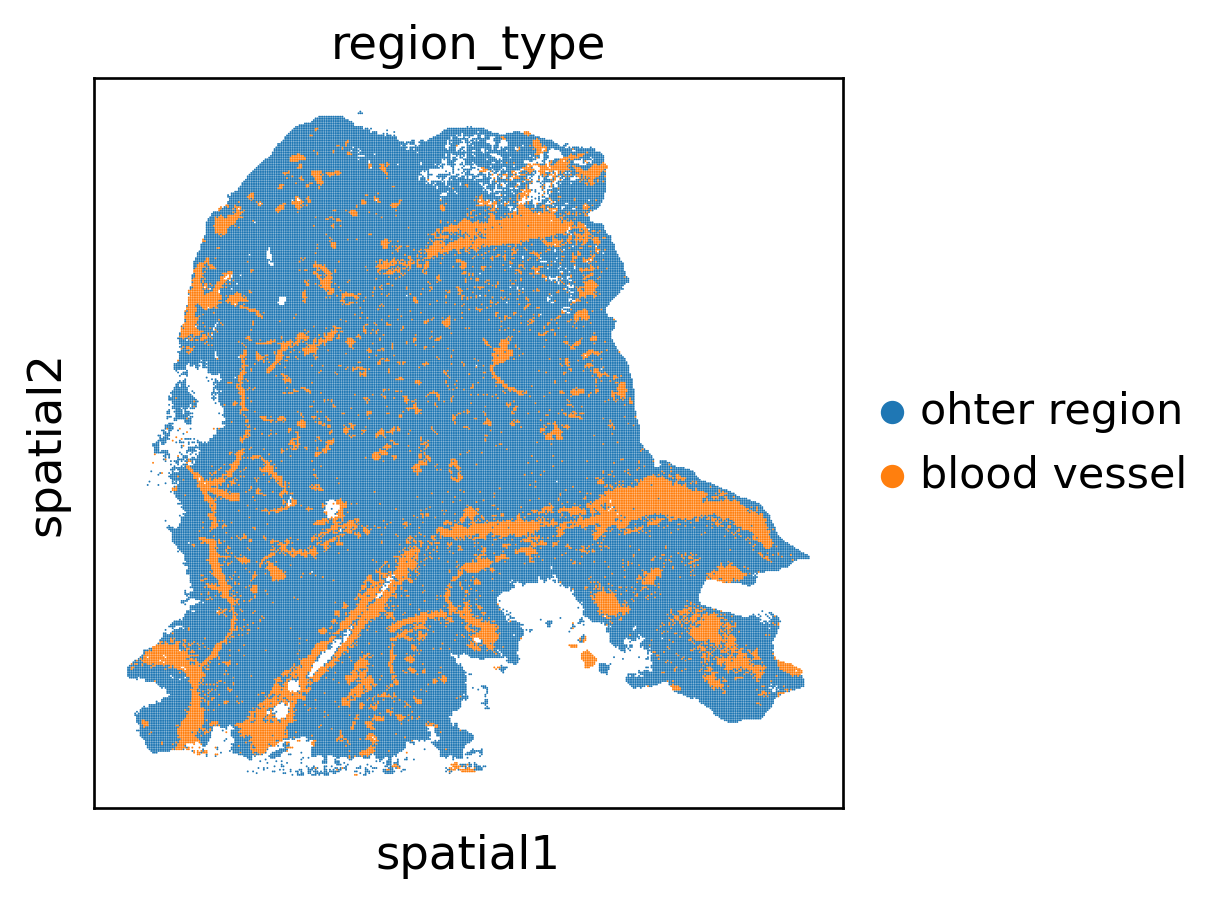

In [148]:
LA.obs['region_type'] = LA.obs.leiden
LA.obs['region_type'] = LA.obs['region_type'].replace('0','ohter region')
LA.obs['region_type'] = LA.obs['region_type'].replace('1','ohter region')
LA.obs['region_type'] = LA.obs['region_type'].replace('2','blood vessel')
sc.pl.embedding(LA,
                basis='spatial',
          color=['region_type'],show=False,color_map='viridis',),

In [149]:
type1=LA.obs['region_type'].to_list()
file_path = '/data/jiangjunyao/ji_stereoseq/spatial/blood vessel/LA_region_type.txt'

with open(file_path, 'w') as file:
    for item in type1:
        file.write(str(item) + '\n')

In [150]:
t_cell = LA[LA.obs['first_type']=='T']

In [151]:
dds=ov.bulk.pyDEG(t_cell.to_df().T)
dds.normalize()
hypoxic_groups=t_cell[t_cell.obs['region_type']=='blood vessel'].obs_names.tolist()
other_groups=t_cell[t_cell.obs['region_type']!='blood vessel'].obs_names.tolist()
print(len(hypoxic_groups))
print(len(other_groups))
result1 = dds.deg_analysis(hypoxic_groups,other_groups,method='wilcox')
dds.foldchange_set(fc_threshold=0.25,
                   pval_threshold=0.1,
                   logp_max=20)

311
37
... Fold change threshold: 0.25


In [152]:
sig_gene = result1.loc[result1['pvalue']<0.05]
sig_gene = sig_gene.loc[sig_gene['abs(log2FC)'] > 0.5]
up_gene = sig_gene.loc[sig_gene['log2FC']>0]
down_gene = sig_gene.loc[sig_gene['log2FC']<0]

In [153]:
print(len(up_gene))
print(len(down_gene))

32
9


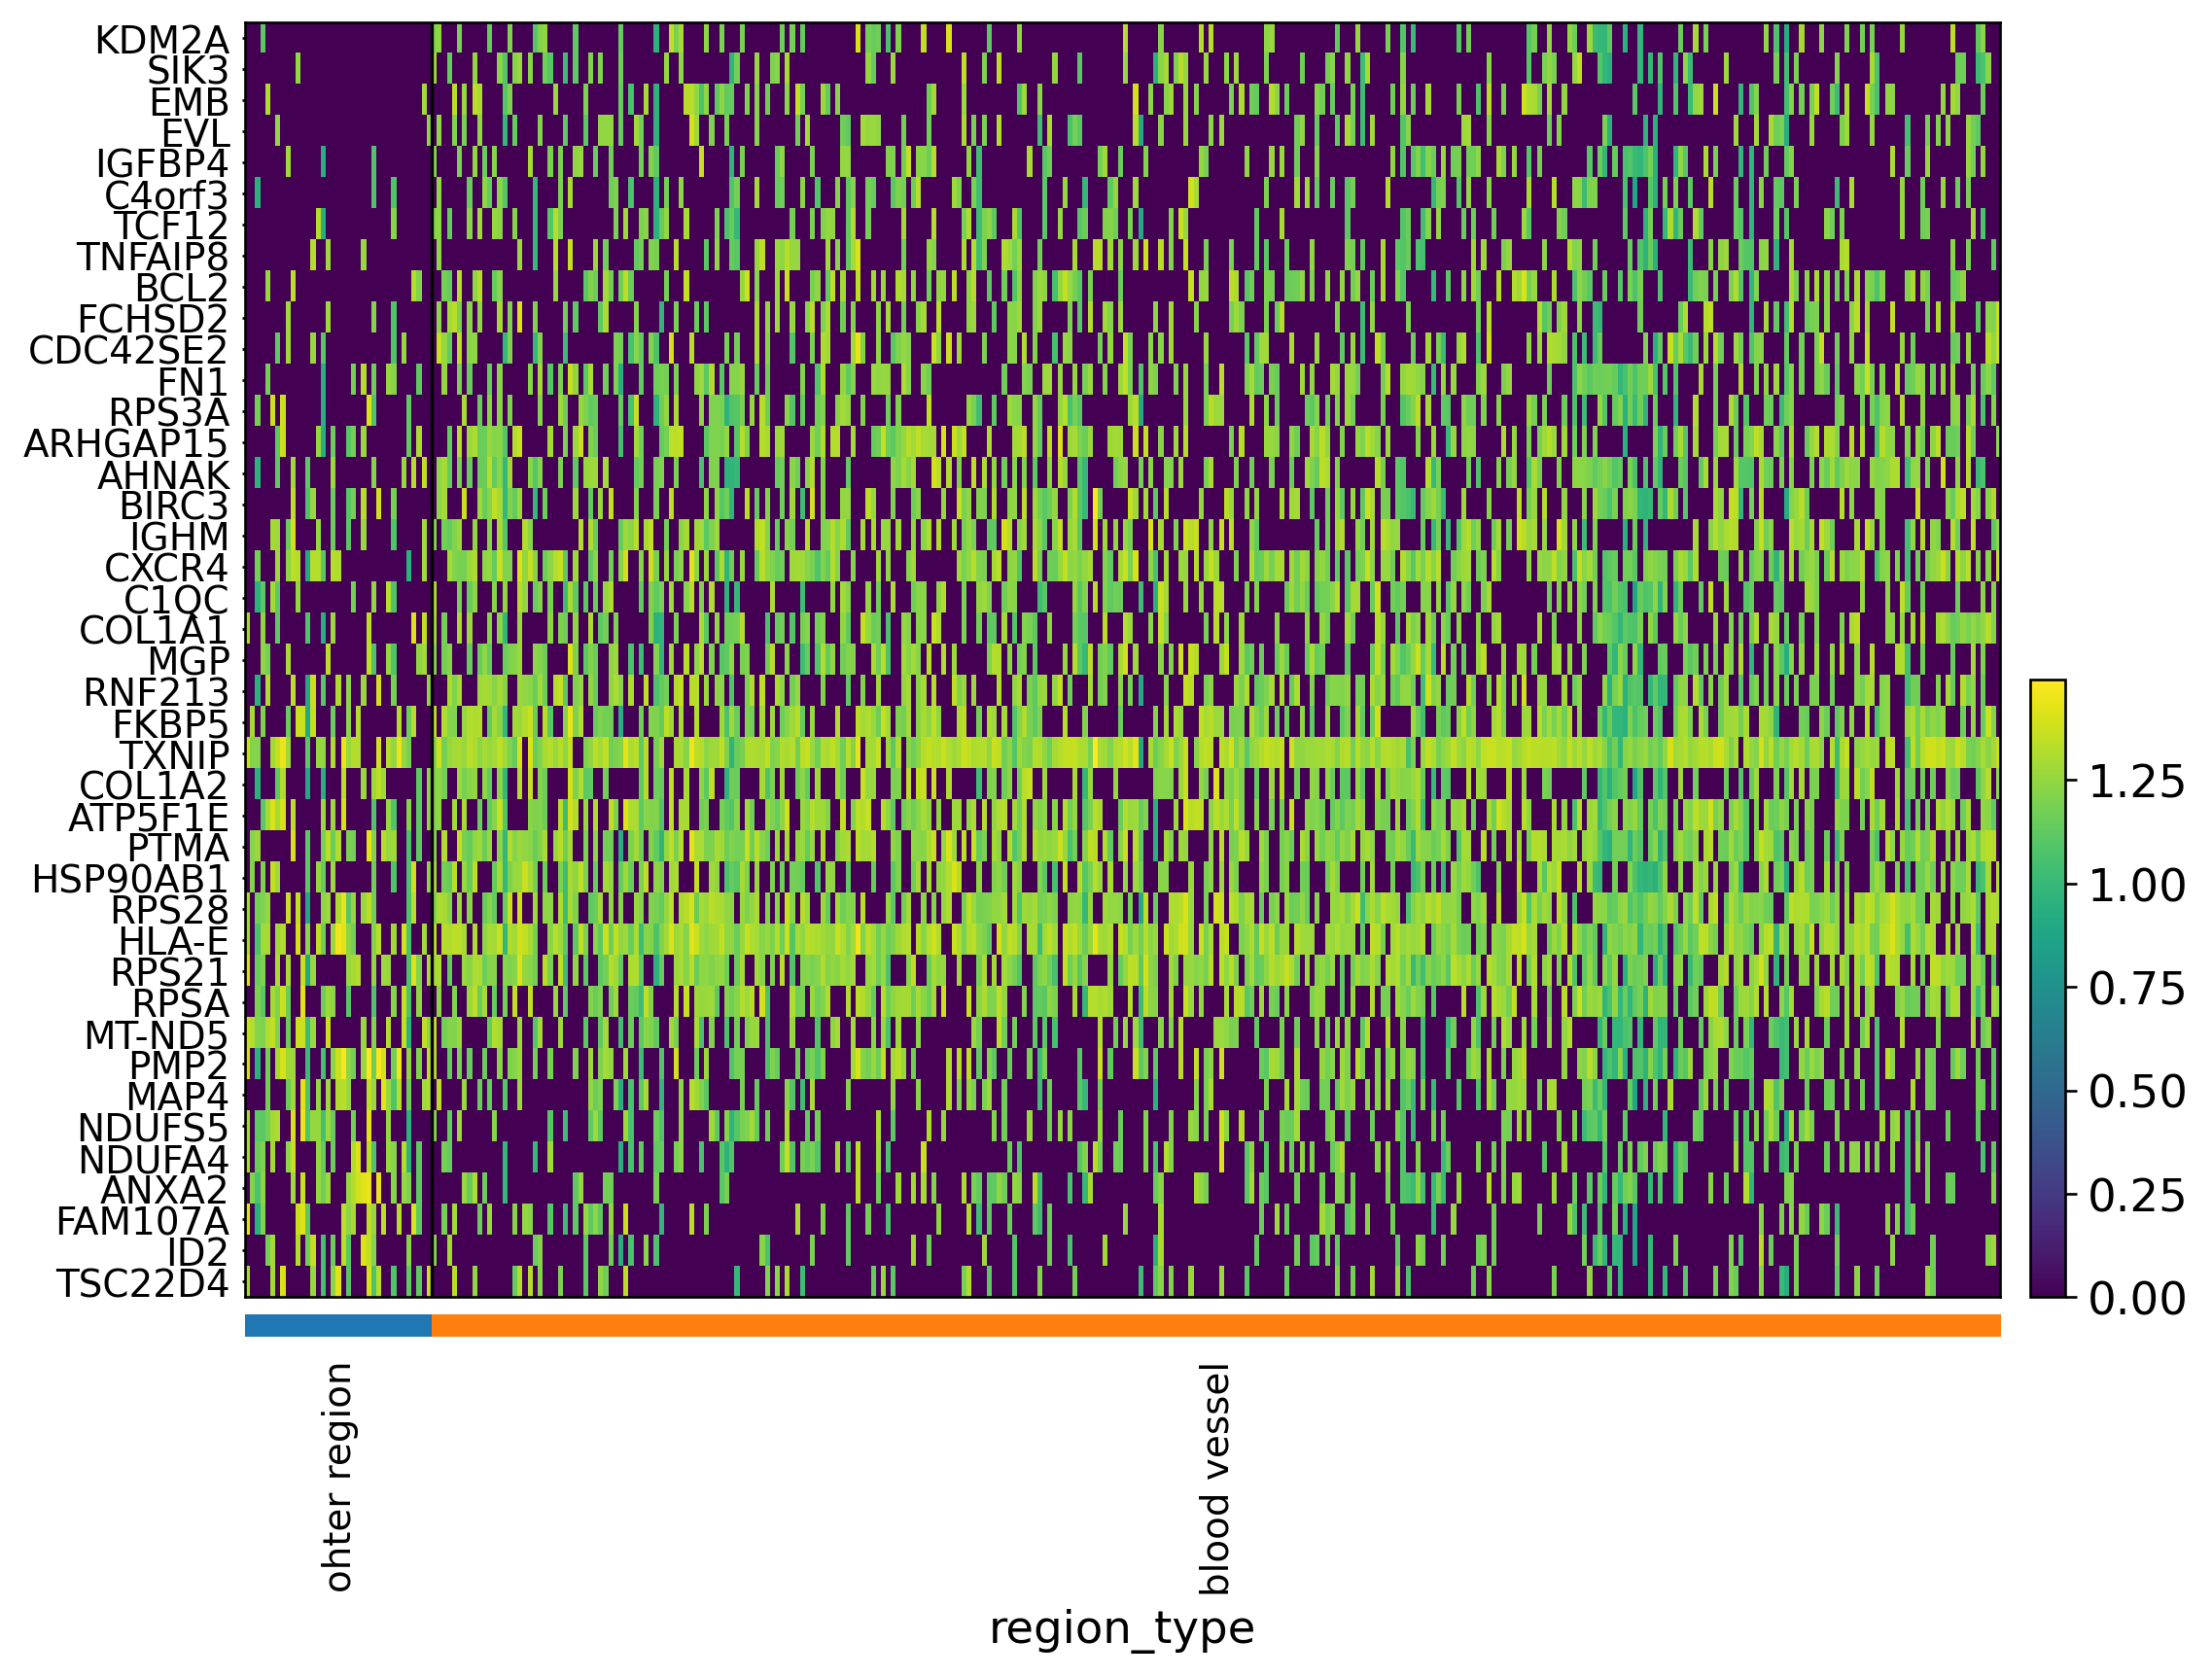

In [157]:
sig_gene = sig_gene.sort_values(by='log2FC', ascending=False)
sc.pl.heatmap(t_cell, var_names=sig_gene.index.tolist(), cmap='viridis', groupby='region_type',swap_axes=True,log=True)


<AxesSubplot: title={'center': 'GO Biological Process enrichment'}, xlabel='Fractions of genes'>

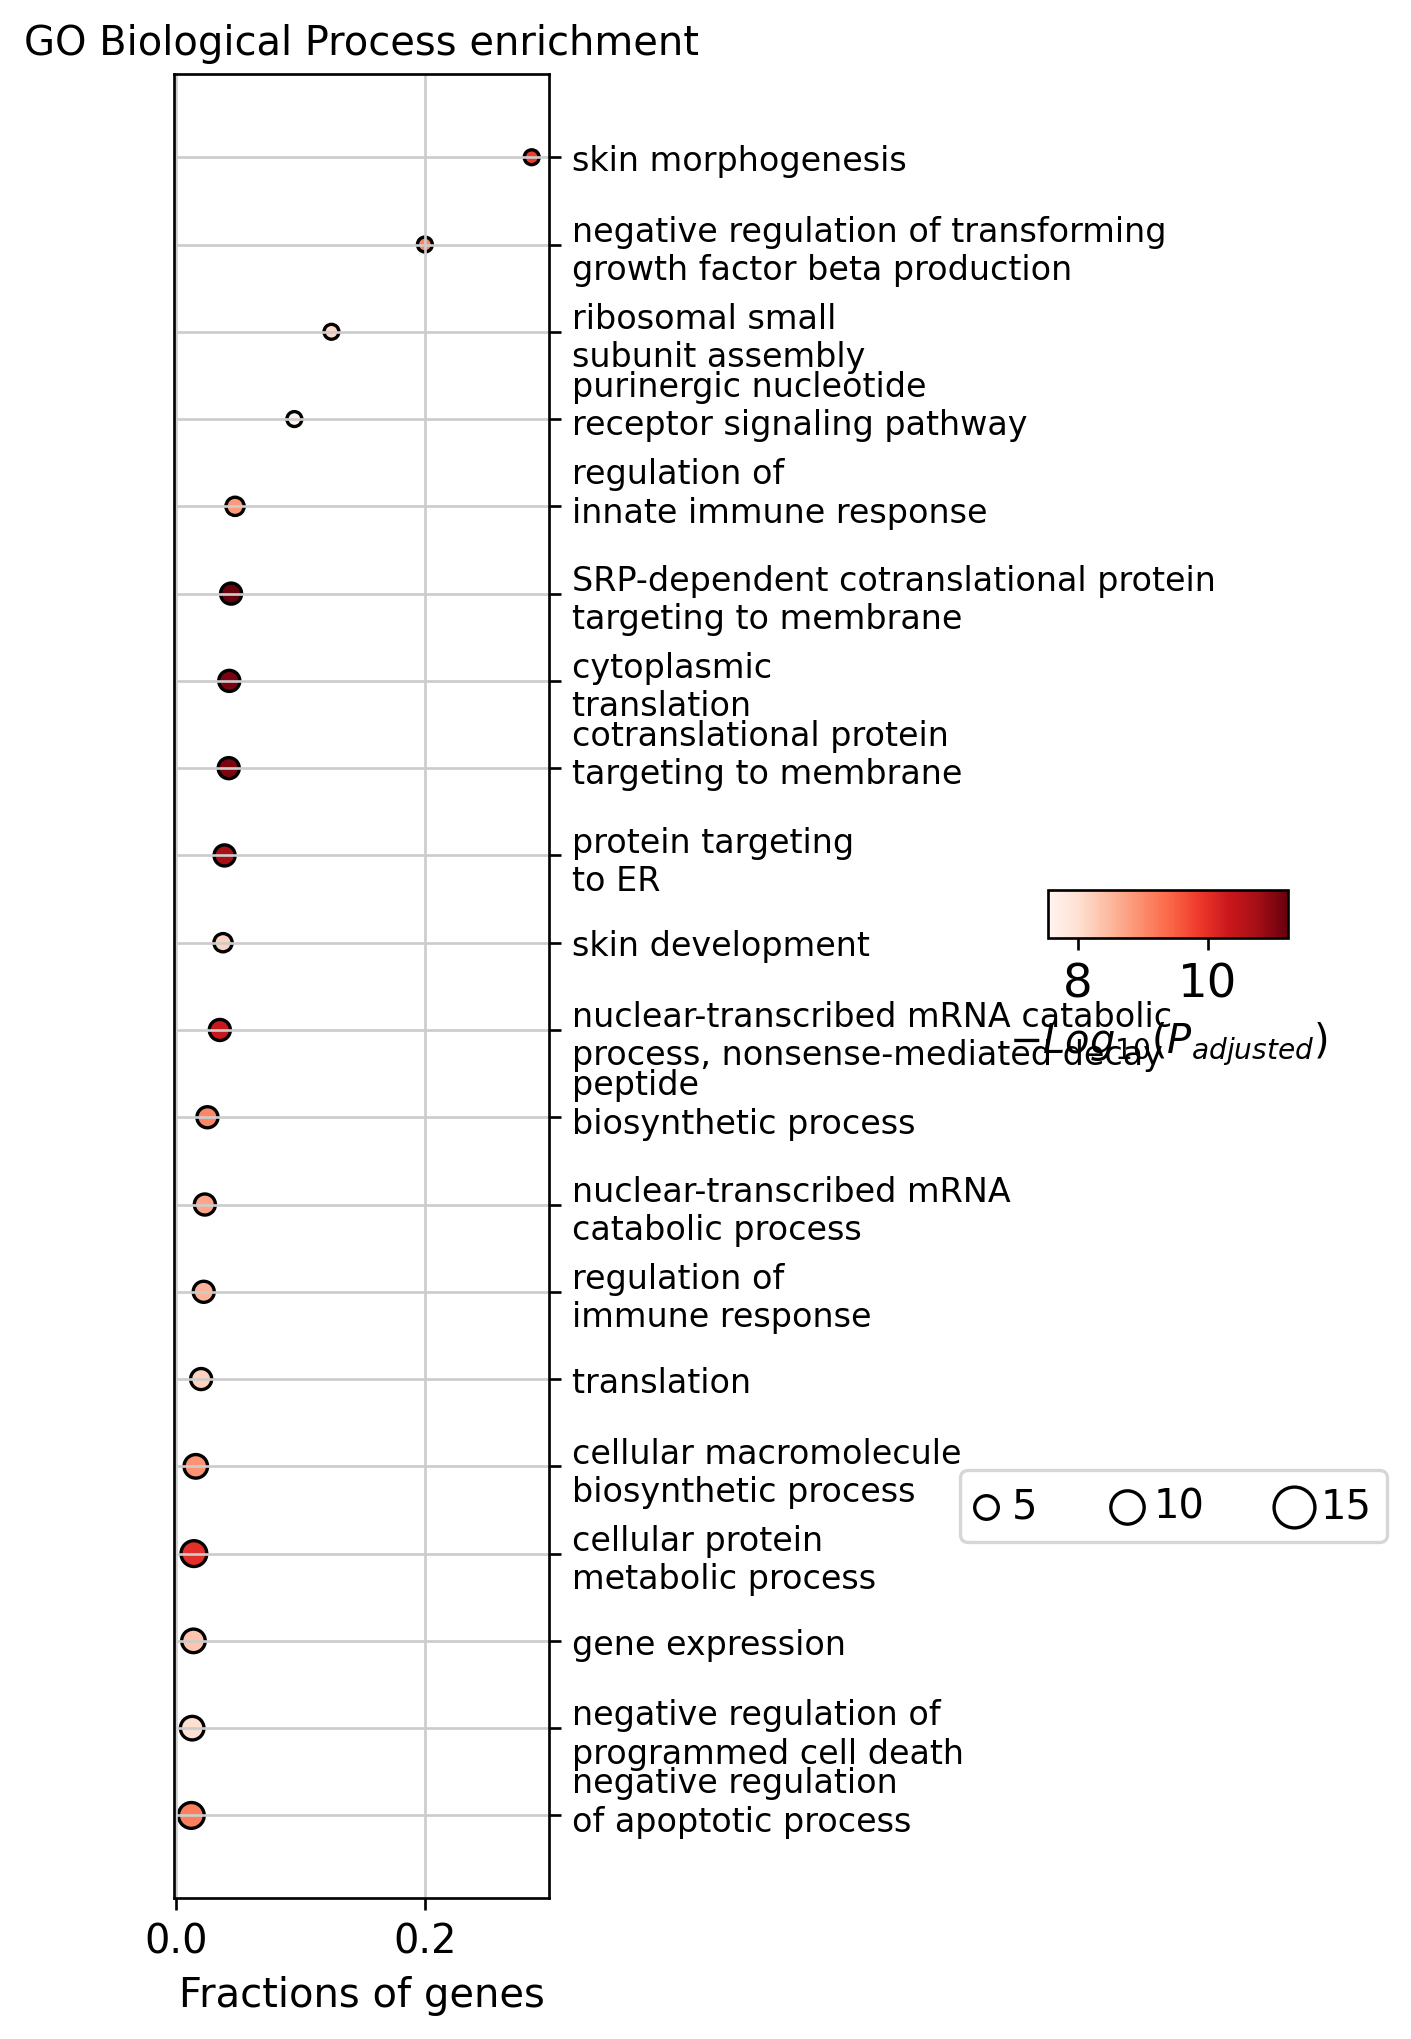

In [132]:
up_go=ov.bulk.geneset_enrichment(gene_list=up_gene.index.to_list(),
                                pathways_dict=pathway_dict,
                                pvalue_type='0.05',
                                organism='Human')
up_go = up_go[up_go['num']>1]
ov.bulk.geneset_plot(up_go,figsize=(2,10),fig_title='GO Biological Process enrichment',
                        cmap='Reds',num=20)

<AxesSubplot: title={'center': 'GO Biological Process enrichment'}, xlabel='Fractions of genes'>

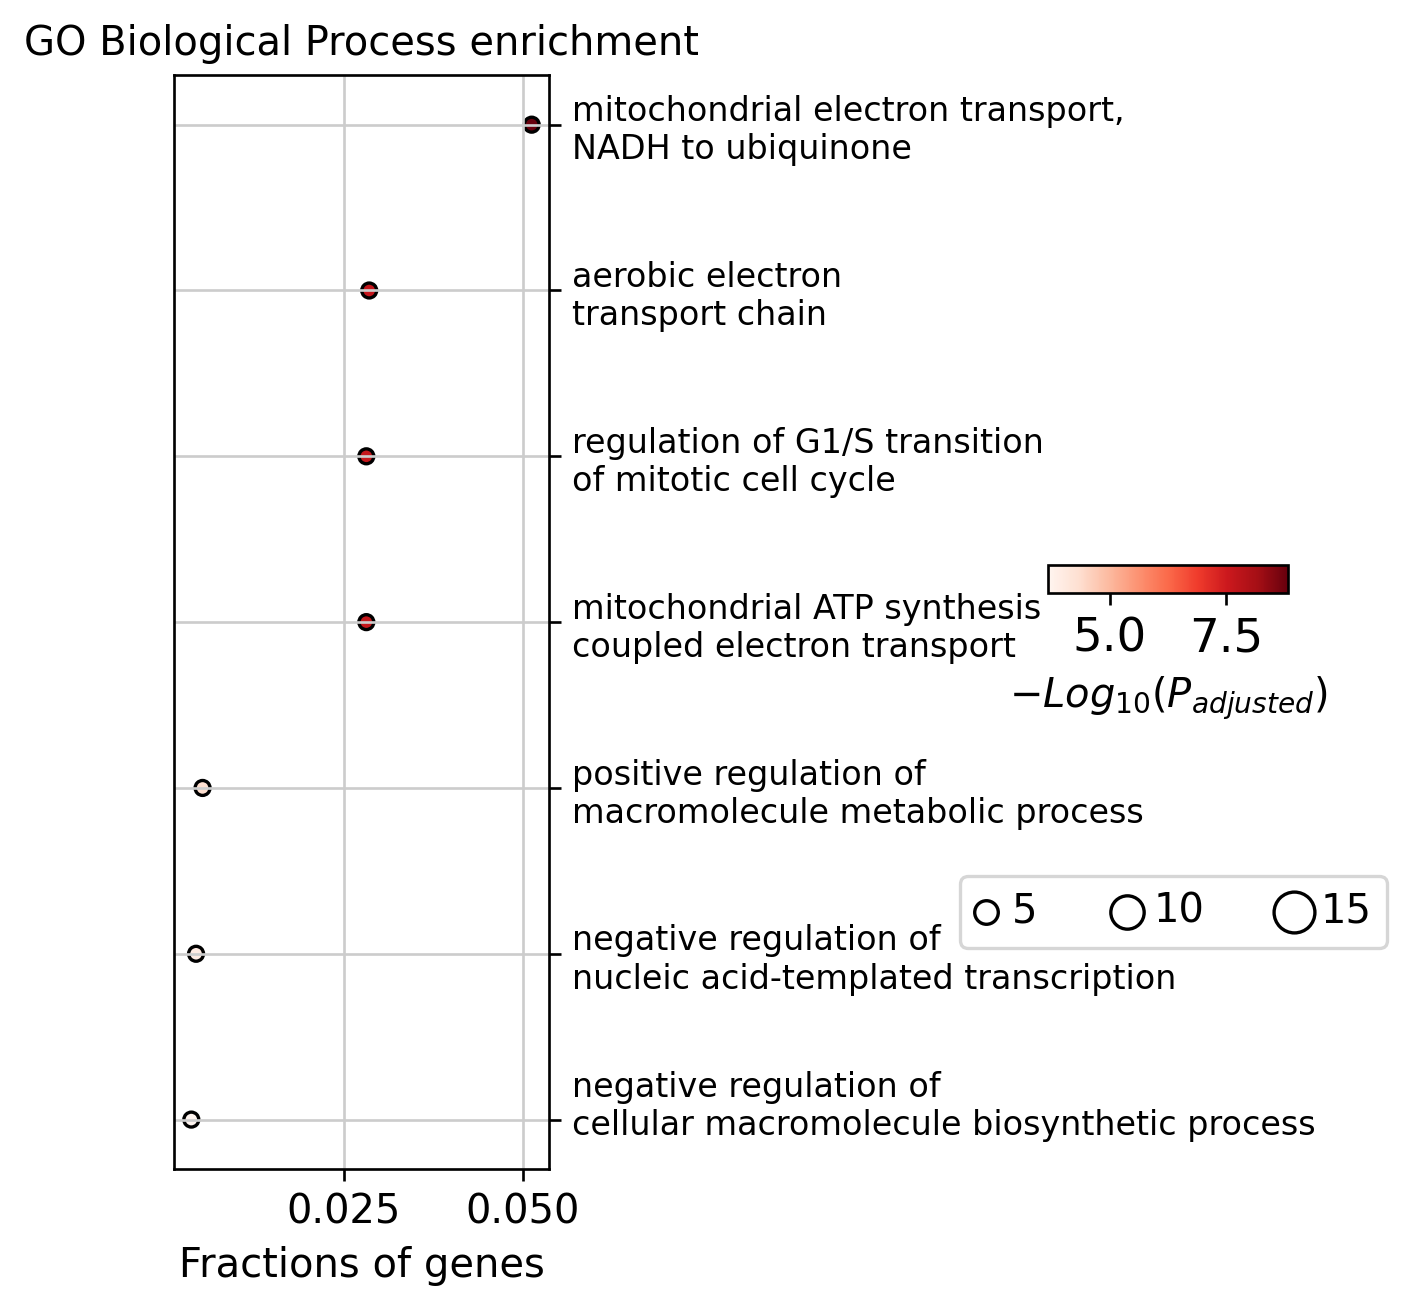

In [133]:
down_go=ov.bulk.geneset_enrichment(gene_list=down_gene.index.to_list(),
                                pathways_dict=pathway_dict,
                                pvalue_type='0.05',
                                organism='Human')
down_go = down_go[down_go['num']>1]
ov.bulk.geneset_plot(down_go,figsize=(2,6),fig_title='GO Biological Process enrichment',
                        cmap='Reds',num=10)

In [25]:
b_cell = LA[LA.obs['first_type']=='B']
dds=ov.bulk.pyDEG(b_cell.to_df().T)
dds.normalize()
hypoxic_groups=b_cell[b_cell.obs['region_type']=='blood vessel'].obs_names.tolist()
other_groups=b_cell[b_cell.obs['region_type']!='blood vessel'].obs_names.tolist()
print(len(hypoxic_groups))
print(len(other_groups))
result1 = dds.deg_analysis(hypoxic_groups,other_groups,method='wilcox')
dds.foldchange_set(fc_threshold=0.25,
                   pval_threshold=0.1,
                   logp_max=20)
sig_gene = result1.loc[result1['pvalue']<0.05]
sig_gene = sig_gene.loc[sig_gene['abs(log2FC)'] > 0.25]
up_gene = sig_gene.loc[sig_gene['log2FC']>0]
down_gene = sig_gene.loc[sig_gene['log2FC']<0]

283
8
... Fold change threshold: 0.25


<AxesSubplot: title={'center': 'GO Biological Process enrichment'}, xlabel='Fractions of genes'>

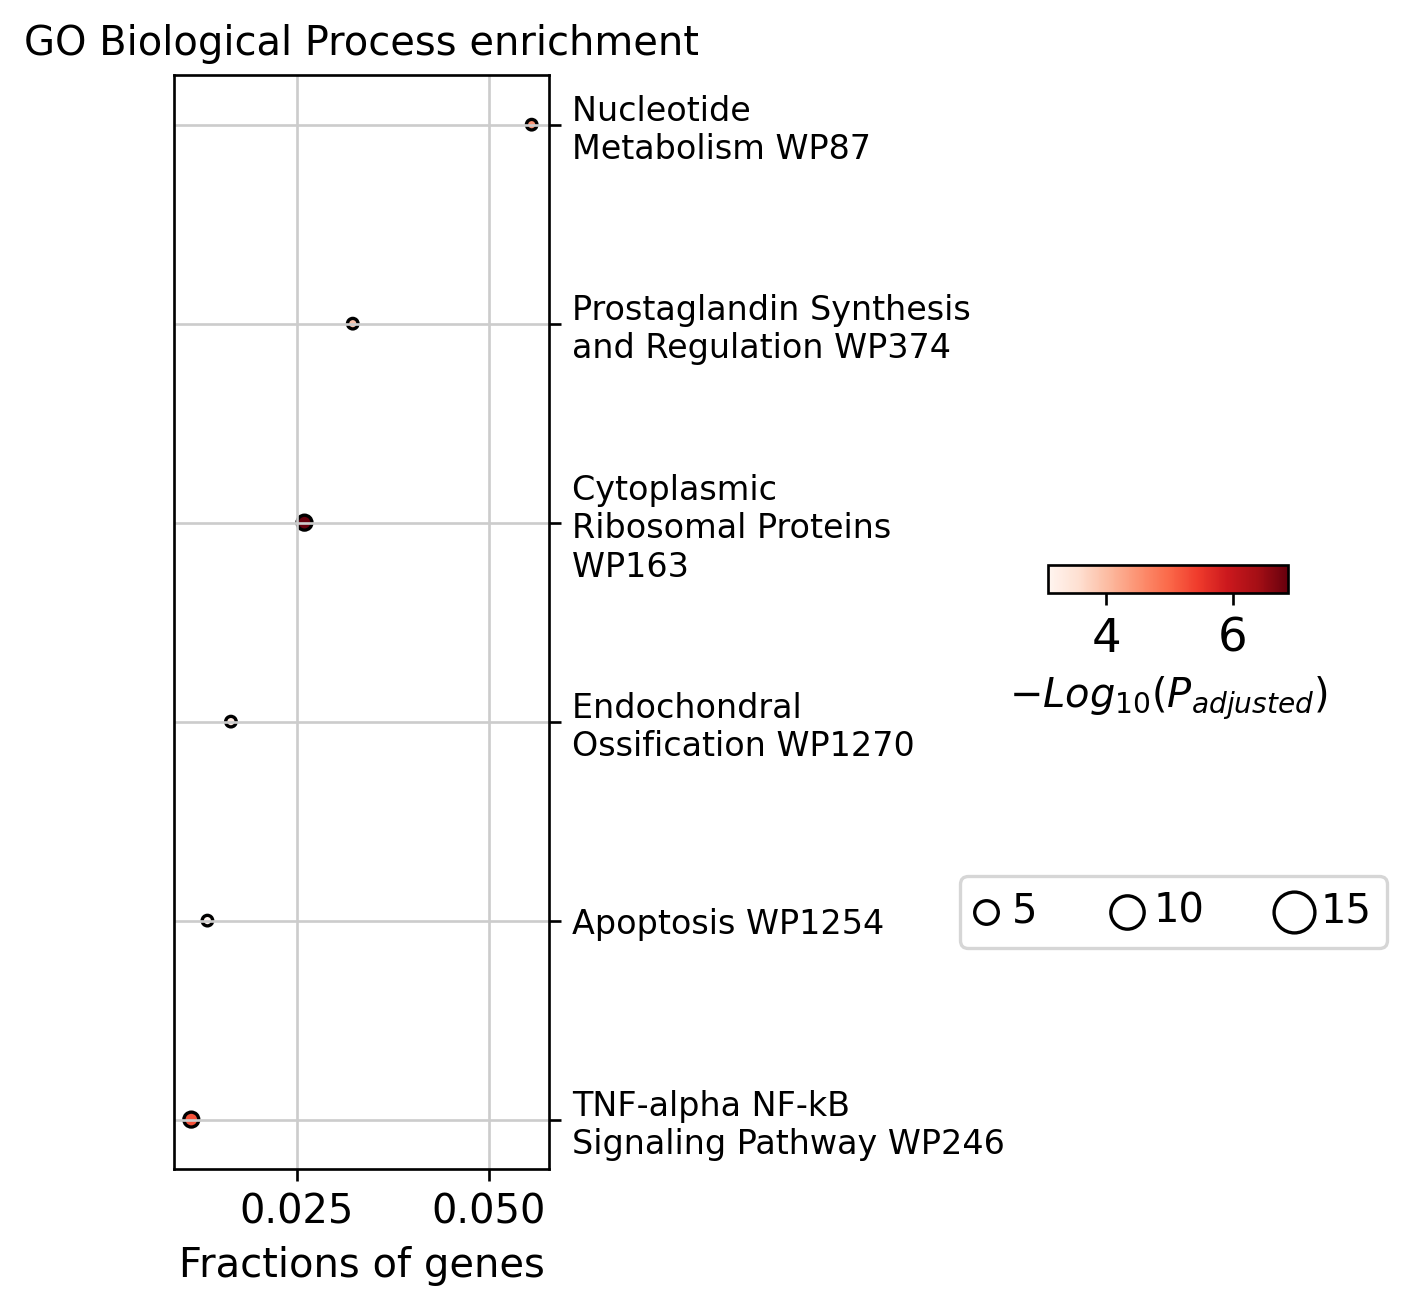

In [27]:
up_go=ov.bulk.geneset_enrichment(gene_list=up_gene.index.to_list(),
                                pathways_dict=pathway_dict,
                                pvalue_type='0.05',
                                organism='Human')
ov.bulk.geneset_plot(up_go,figsize=(2,6),fig_title='GO Biological Process enrichment',
                        cmap='Reds')

<AxesSubplot: title={'center': 'GO Biological Process enrichment'}, xlabel='Fractions of genes'>

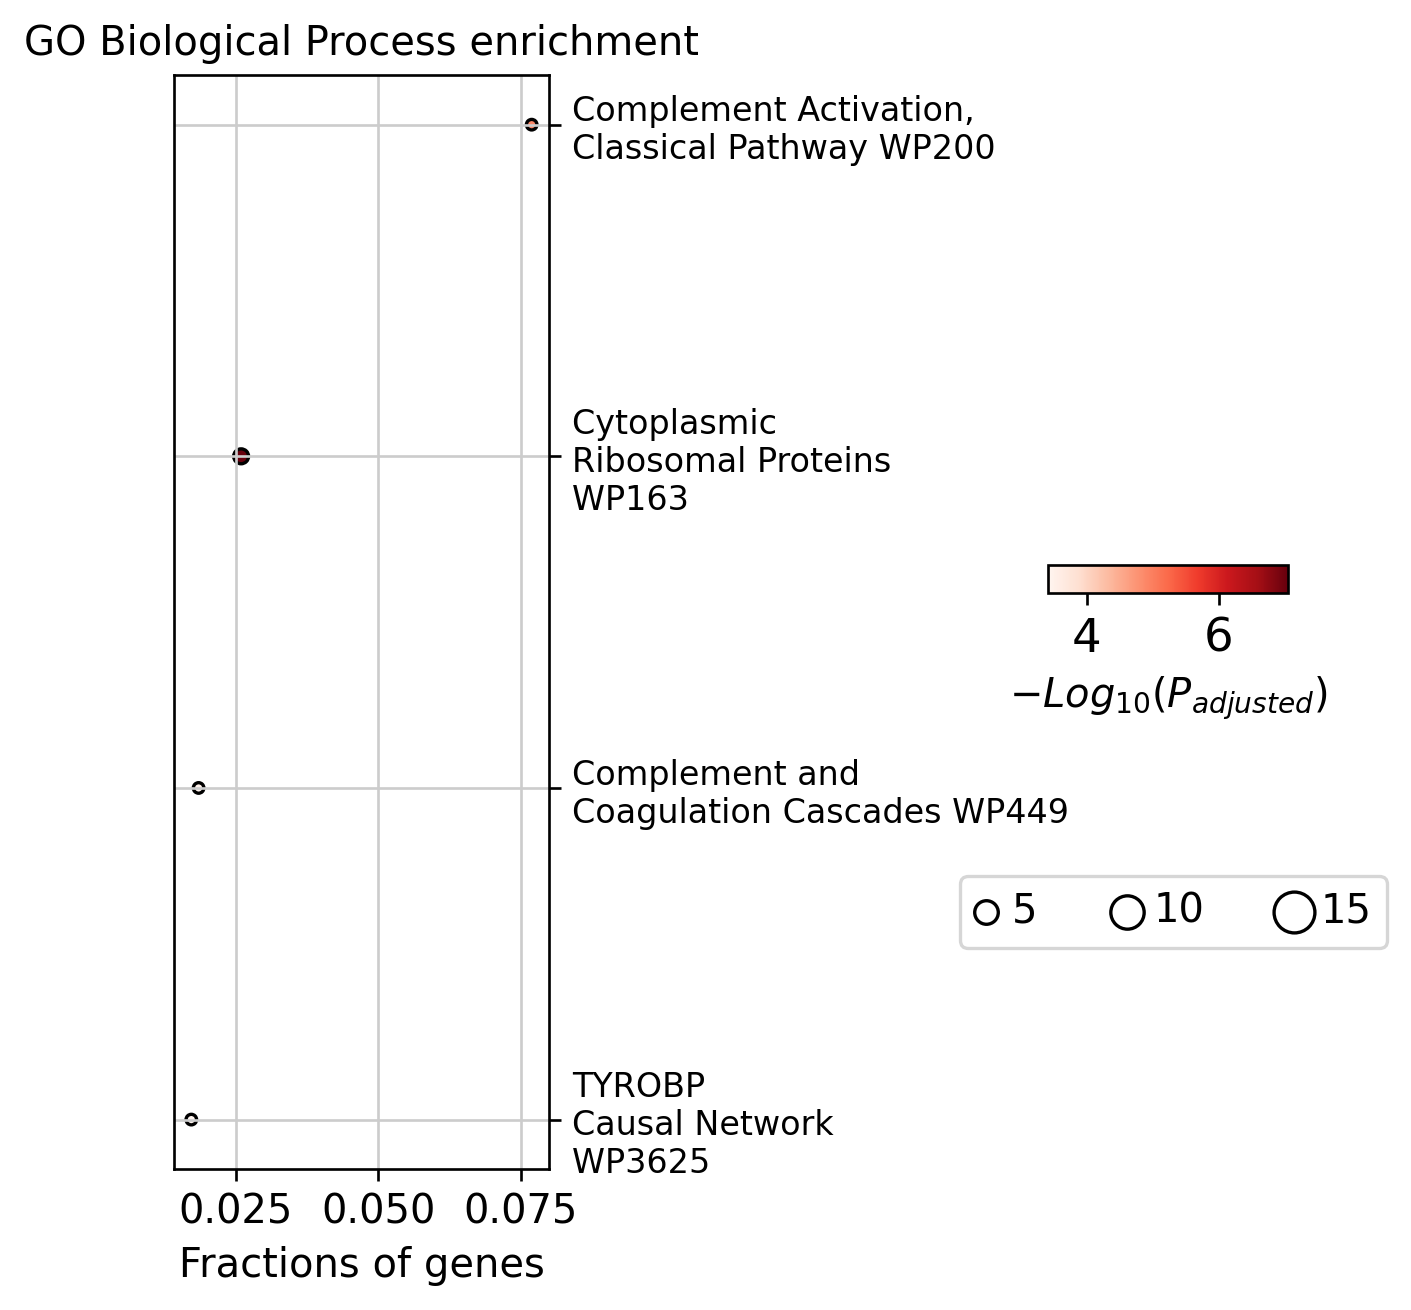

In [28]:
down_go=ov.bulk.geneset_enrichment(gene_list=down_gene.index.to_list(),
                                pathways_dict=pathway_dict,
                                pvalue_type='0.05',
                                organism='Human')
ov.bulk.geneset_plot(down_go,figsize=(2,6),fig_title='GO Biological Process enrichment',
                        cmap='Reds')

In [ ]:
apo_re_reti_stress_gene = pathway_dict['intrinsic apoptotic signaling pathway in response to endoplasmic reticulum stress (GO:0070059)'] 
apo_process = pathway_dict['apoptotic process (GO:0006915)'] 
lip_st = pathway_dict['regulation of lipid storage (GO:0010883)'] 
lip_meta = pathway_dict['regulation of lipid metabolic process (GO:0019216)'] 
endopla_reti_stre = pathway_dict['response to endoplasmic reticulum stress (GO:0034976)'] 
regu_endopla_reti_stre = pathway_dict['regulation of response to endoplasmic reticulum stress (GO:1905897)'] 
nfkappb = pathway_dict['regulation of NIK/NF-kappaB signaling (GO:1901222)'] 
pos_nfkappb = pathway_dict['positive regulation of NF-kappaB transcription factor activity (GO:0051092)']
t_apo = pathway_dict['T cell apoptotic process (GO:0070231)']
t_diff = pathway_dict['T cell differentiation (GO:0030217)']
t_act = pathway_dict['T cell activation (GO:0042110)']
reg_t_cyto = pathway_dict['regulation of T cell mediated cytotoxicity (GO:0001914)']
reg_t_tumor = pathway_dict['regulation of T cell mediated immune response to tumor cell (GO:0002840)']
dna_rep = pathway_dict['DNA replication (GO:0006260)']

In [91]:
geneset_names=['intrinsic apoptotic signaling pathway in response to endoplasmic reticulum stress (GO:0070059)',
               'apoptotic process (GO:0006915)','regulation of lipid storage (GO:0010883)',
               'regulation of lipid metabolic process (GO:0019216)',
               'response to endoplasmic reticulum stress (GO:0034976)',
               'regulation of response to endoplasmic reticulum stress (GO:1905897)',
               'regulation of NIK/NF-kappaB signaling (GO:1901222)',
               'positive regulation of NF-kappaB transcription factor activity (GO:0051092)',
               'T cell apoptotic process (GO:0070231)',
               'T cell differentiation (GO:0030217)',
               'T cell activation (GO:0042110)',
               'regulation of T cell mediated cytotoxicity (GO:0001914)',
               'regulation of T cell mediated immune response to tumor cell (GO:0002840)',
               'DNA replication (GO:0006260)'
              ]
ov.single.pathway_aucell(t_cell,
                            pathway_names=geneset_names,
                            pathways_dict=pathway_dict)

ctxcore have been install version: 0.2.0


In [116]:
blood_region = []
for i in t_cell.obs.region_type:
    if i =='blood vessel':
        blood_region.append('in blood vessel')
    else:
        blood_region.append('out blood vessel')
t_cell.obs['blood_region'] = blood_region

In [120]:
t_cell.obs.to_csv('/data/jiangjunyao/ji_stereoseq/spatial/blood vessel/t_cell_function.csv')